In [1]:
# For processing the data
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline
sns.set_style("white") # set style for seaborn plots

# Machine learning
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2, SelectFromModel
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer, log_loss
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
                              GradientBoostingClassifier, VotingClassifier, 
                              RandomForestClassifier, AdaBoostClassifier)
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import shutil
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, ndimage
from joblib import Memory

from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [3]:
data = pd.read_csv("data.csv")
data = pd.DataFrame(data)
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
irrelevant = ["lon", "lat", "team_id", "team_name", "game_id", "game_event_id", "game_date"]
data = data.drop(columns=irrelevant)
data

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,167,72,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,138,175,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,0,0,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL @ POR,POR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,1,48,6,4,1,1999-00,5,4,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,LAL vs. IND,IND,30693
30693,Tip Shot,Tip Shot,0,0,6,4,1,1999-00,5,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL vs. IND,IND,30694
30694,Running Jump Shot,Jump Shot,-134,166,3,4,1,1999-00,28,21,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL vs. IND,IND,30695
30695,Jump Shot,Jump Shot,31,267,2,4,1,1999-00,10,26,0.0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,LAL vs. IND,IND,30696


In [5]:
tr = data

In [6]:
tr_labels = data["shot_made_flag"]
tr_labels = tr_labels.dropna()
tr_labels

1        0.0
2        1.0
3        0.0
4        1.0
5        0.0
        ... 
30691    0.0
30692    0.0
30694    1.0
30695    0.0
30696    0.0
Name: shot_made_flag, Length: 25697, dtype: float64

In [7]:
tr_num = tr.select_dtypes(include='int64')
tr_num

,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_id
0,167,72,10,1,0,27,18,1
1,-157,0,10,1,0,22,15,2
2,-101,135,7,1,0,45,16,3
3,138,175,6,1,0,52,22,4
4,0,0,6,2,0,19,0,5
...,...,...,...,...,...,...,...,...
30692,1,48,6,4,1,5,4,30693
30693,0,0,6,4,1,5,0,30694
30694,-134,166,3,4,1,28,21,30695
30695,31,267,2,4,1,10,26,30696


In [8]:
tr_cat = tr.select_dtypes(include='object')
tr_cat

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
0,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR
1,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR
2,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR
3,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,LAL @ POR,POR
4,Driving Dunk Shot,Dunk,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL @ POR,POR
...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,1999-00,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,LAL vs. IND,IND
30693,Tip Shot,Tip Shot,1999-00,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL vs. IND,IND
30694,Running Jump Shot,Jump Shot,1999-00,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL vs. IND,IND
30695,Jump Shot,Jump Shot,1999-00,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,LAL vs. IND,IND


In [9]:
le = LabelEncoder()

In [10]:
# Turning string data into numbers
tr["action_type"] = le.fit_transform(tr["action_type"])
tr["season"] = le.fit_transform(tr["season"])
tr["combined_shot_type"] = le.fit_transform(tr["combined_shot_type"])
tr["shot_type"] = le.fit_transform(tr["shot_type"])
tr["shot_zone_area"] = le.fit_transform(tr["shot_zone_area"])
tr["shot_zone_basic"] = le.fit_transform(tr["shot_zone_basic"])
tr["shot_zone_range"] = le.fit_transform(tr["shot_zone_range"])
tr["matchup"] = le.fit_transform(tr["matchup"])
tr["opponent"] = le.fit_transform(tr["opponent"])

In [11]:
tr.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent,shot_id
0,26,3,167,72,10,1,0,4,27,18,NaN,0,5,4,0,28,25,1
1,26,3,-157,0,10,1,0,4,22,15,0.0,0,3,4,2,28,25,2
2,26,3,-101,135,7,1,0,4,45,16,1.0,0,2,4,0,28,25,3
3,26,3,138,175,6,1,0,4,52,22,0.0,0,4,4,0,28,25,4
4,5,1,0,0,6,2,0,4,19,0,1.0,0,1,5,4,28,25,5


In [12]:
tr_test = tr[tr["shot_made_flag"].isnull()]
X_test = tr_test.drop('shot_made_flag', axis=1)
X_test

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent,shot_id
0,26,3,167,72,10,1,0,4,27,18,0,5,4,0,28,25,1
7,26,3,1,28,8,3,0,4,5,2,0,1,5,4,28,25,8
16,12,4,0,0,0,1,0,4,1,0,0,1,5,4,71,30,17
19,12,4,0,0,10,3,0,4,46,0,0,1,5,4,71,30,20
32,26,3,163,76,11,1,0,4,26,17,0,5,4,0,35,31,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30668,26,3,-23,222,7,4,1,3,27,22,0,1,4,0,12,11,30669
30680,50,5,0,0,0,2,1,3,40,0,0,1,5,4,49,11,30681
30682,41,3,-68,48,11,3,1,3,30,8,0,3,2,2,49,11,30683
30686,41,3,16,93,5,3,1,3,37,9,0,1,2,2,49,11,30687


In [13]:
X_test.shape

(5000, 17)

In [14]:
tr_data = tr.dropna()

In [15]:
target_values = tr_data['shot_made_flag'].values

In [16]:
target_values.shape

(25697,)

In [17]:
tr_train = tr_data.drop(columns="shot_made_flag", axis=1)

In [18]:
tr_train

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent,shot_id
1,26,3,-157,0,10,1,0,4,22,15,0,3,4,2,28,25,2
2,26,3,-101,135,7,1,0,4,45,16,0,2,4,0,28,25,3
3,26,3,138,175,6,1,0,4,52,22,0,4,4,0,28,25,4
4,5,1,0,0,6,2,0,4,19,0,0,1,5,4,28,25,5
5,26,3,-145,-11,9,3,0,4,32,14,0,3,4,2,28,25,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,12,4,0,0,7,4,1,3,4,0,0,1,5,4,49,11,30692
30692,26,3,1,48,6,4,1,3,5,4,0,1,2,4,49,11,30693
30694,41,3,-134,166,3,4,1,3,28,21,0,2,4,0,49,11,30695
30695,26,3,31,267,2,4,1,3,10,26,1,1,0,1,49,11,30696


In [19]:
attribute_values = tr_train.values

In [20]:
attribute_values.shape

(25697, 17)

In [22]:
attribute_names = ['action_type',
                  'combined_shot_type',
                  'loc_x',
                  'loc_y',
                  'minutes_remaining',
                  'period',
                  'playoffs',
                  'season',
                  'seconds_remaining',
                  'shot_distance',
                  'shot_type',
                  'shot_zone_area',
                  'shot_zone_basic',
                  'shot_zone_range',
                  'matchup',
                  'opponent',
                  'shot_id']

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

In [24]:
standardizer = StandardScaler()
X_std = standardizer.fit_transform(attribute_values)

In [25]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(X_std, target_values, test_size=0.2, random_state=0)

In [26]:
features_train.shape

(20557, 17)

In [27]:
from keras import models
from keras import layers

Using TensorFlow backend.


In [28]:
network = models.Sequential()
network.add(layers.Dense(units=8,activation="sigmoid",
                        input_shape=(features_train.shape[1],)))
network.add(layers.Dense(units=1,activation="sigmoid"))

In [30]:
network.compile(loss="mean_squared_error", optimizer="sgd", metrics=["accuracy"])

In [91]:
history = network.fit(features_train, target_train,
                     epochs=1000, verbose=0, batch_size=10,
                     validation_data=(features_train, target_train))

In [32]:
history

In [33]:
history.history

{'val_loss': [0.24906564951551885,
  0.24524946990728483,
  0.24295878042250157,
  0.24136211862300583,
  0.2401847258089129,
  0.23927412385020141,
  0.23854901507687476,
  0.2379549770783304,
  0.237446009589406,
  0.23701496595897267],
 'val_accuracy': [0.5707544684410095,
  0.5759108662605286,
  0.582088828086853,
  0.5856399536132812,
  0.589142382144928,
  0.5929853320121765,
  0.5947365760803223,
  0.5963419079780579,
  0.5972175002098083,
  0.597898542881012],
 'loss': [0.2552416333299426,
  0.24693920846888776,
  0.24406554948864914,
  0.24215498331479537,
  0.24078568304571457,
  0.23974482881922535,
  0.23893796488481048,
  0.23827600234192262,
  0.23773126546908732,
  0.237258025268674],
 'accuracy': [0.56073356,
  0.5728949,
  0.5793647,
  0.5836941,
  0.58802354,
  0.59040713,
  0.5940069,
  0.5952717,
  0.5972175,
  0.59760666]}

In [92]:
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

In [93]:
epoch_count = range(1, len(training_loss) + 1)
epoch_count

range(1, 1001)

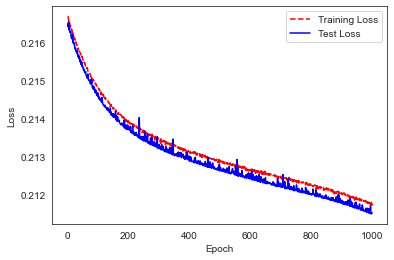

In [94]:
import matplotlib.pyplot as plt
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

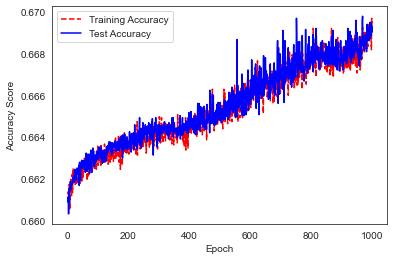

In [95]:
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show()

In [96]:
predicted_target = network.predict(features_test)

In [97]:
predicted_target

array([[0.3565966 ],
       [0.29471213],
       [0.31151885],
       ...,
       [0.5657924 ],
       [0.06580145],
       [0.29138306]], dtype=float32)

In [98]:
test_data = pd.read_csv("test_set.csv")
test_data = test_data.drop(test_data.columns[0], axis = 1)
test_data_id = test_data["shot_id"]
test_data_id = pd.DataFrame(test_data_id)

In [99]:
pred = network.predict(X_test)

In [100]:
pred.shape

(5000, 1)

In [101]:
predictions = pd.DataFrame(pred)

In [102]:
test_data_id

,shot_id
0,1
1,8
2,17
3,20
4,33
...,...
4995,30669
4996,30681
4997,30683
4998,30687


In [103]:
submission_file = pd.concat([test_data_id, predictions], axis=1)
submission_file.columns = ["shot_id", "shot_made_flag"]

In [89]:
submission_file

,shot_id,shot_made_flag
0,1,0.434383
1,8,0.485471
2,17,0.568518
3,20,0.571557
4,33,0.422813
...,...,...
4995,30669,0.072318
4996,30681,0.072318
4997,30683,0.072318
4998,30687,0.072318


In [104]:
submission_file.to_csv('submission_file_NN.csv')